In [1]:
import sys
sys.path.append('..')  # or the absolute path to your project root

# !pip install scikit-learn
# pip install umap-learn


In [15]:
# ── CONFIG ────────────────────────────────────────────────────────────────────

# Number of clusters to form. The dendrogram is cut horizontally to produce exactly this many groups.
# Set to None if using DISTANCE_THRESHOLD instead.
N_CLUSTERS = 7

# How distance between merging clusters is measured:
#   'ward'     — minimizes within-cluster variance (best default, produces compact equal-sized clusters)
#   'complete' — uses max distance between points in two clusters (tight, well-separated clusters)
#   'average'  — uses mean distance between all point pairs (balanced, general-purpose)
#   'single'   — uses min distance between points (finds elongated/chain-like clusters, sensitive to noise)
LINKAGE_METHOD = 'average'

# Max PCA dimensions before clustering. Reduces noise and speeds up computation.
# Only applied if the dataset has more features than this value.
N_COMPONENTS = 200

# Alternative to N_CLUSTERS: cut the dendrogram at a specific distance height.
# Lets the data decide how many clusters to form. Read the value from the dendrogram y-axis.
# Set N_CLUSTERS = None when using this.
DISTANCE_THRESHOLD = None

OUTLIER_PERCENTILE = 2  # Remove top/bottom X% of points from plots. Set to 0 to disable.


(2709, 5633)
(2709, 99)
(2709, 99)
(2709, 131)
(2709, 131)
(2709, 165)
Hopkins Statistic: 0.9706
Hopkins Statistic: 0.8735
Hopkins Statistic: 0.8658
Hopkins Statistic: 0.7607
Hopkins Statistic: 0.7729
Hopkins Statistic: 0.9733

--- Processing: train ---
Computing linkage matrix (method=average)...
Agglomerative Clustering found 7 clusters.
  Cluster 0: 2161 users (99.7%)
  Cluster 1: 1 users (0.0%)
  Cluster 2: 1 users (0.0%)
  Cluster 3: 1 users (0.0%)
  Cluster 4: 1 users (0.0%)
  Cluster 5: 1 users (0.0%)
  Cluster 6: 1 users (0.0%)
Saved results for train to '../data/tmp/ahc/' folder.


/Users/andy/anaconda3/envs/datathon/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/andy/anaconda3/envs/datathon/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Outlier removal (2th percentile): hiding ~145 PCA / ~171 UMAP outlier points from plots


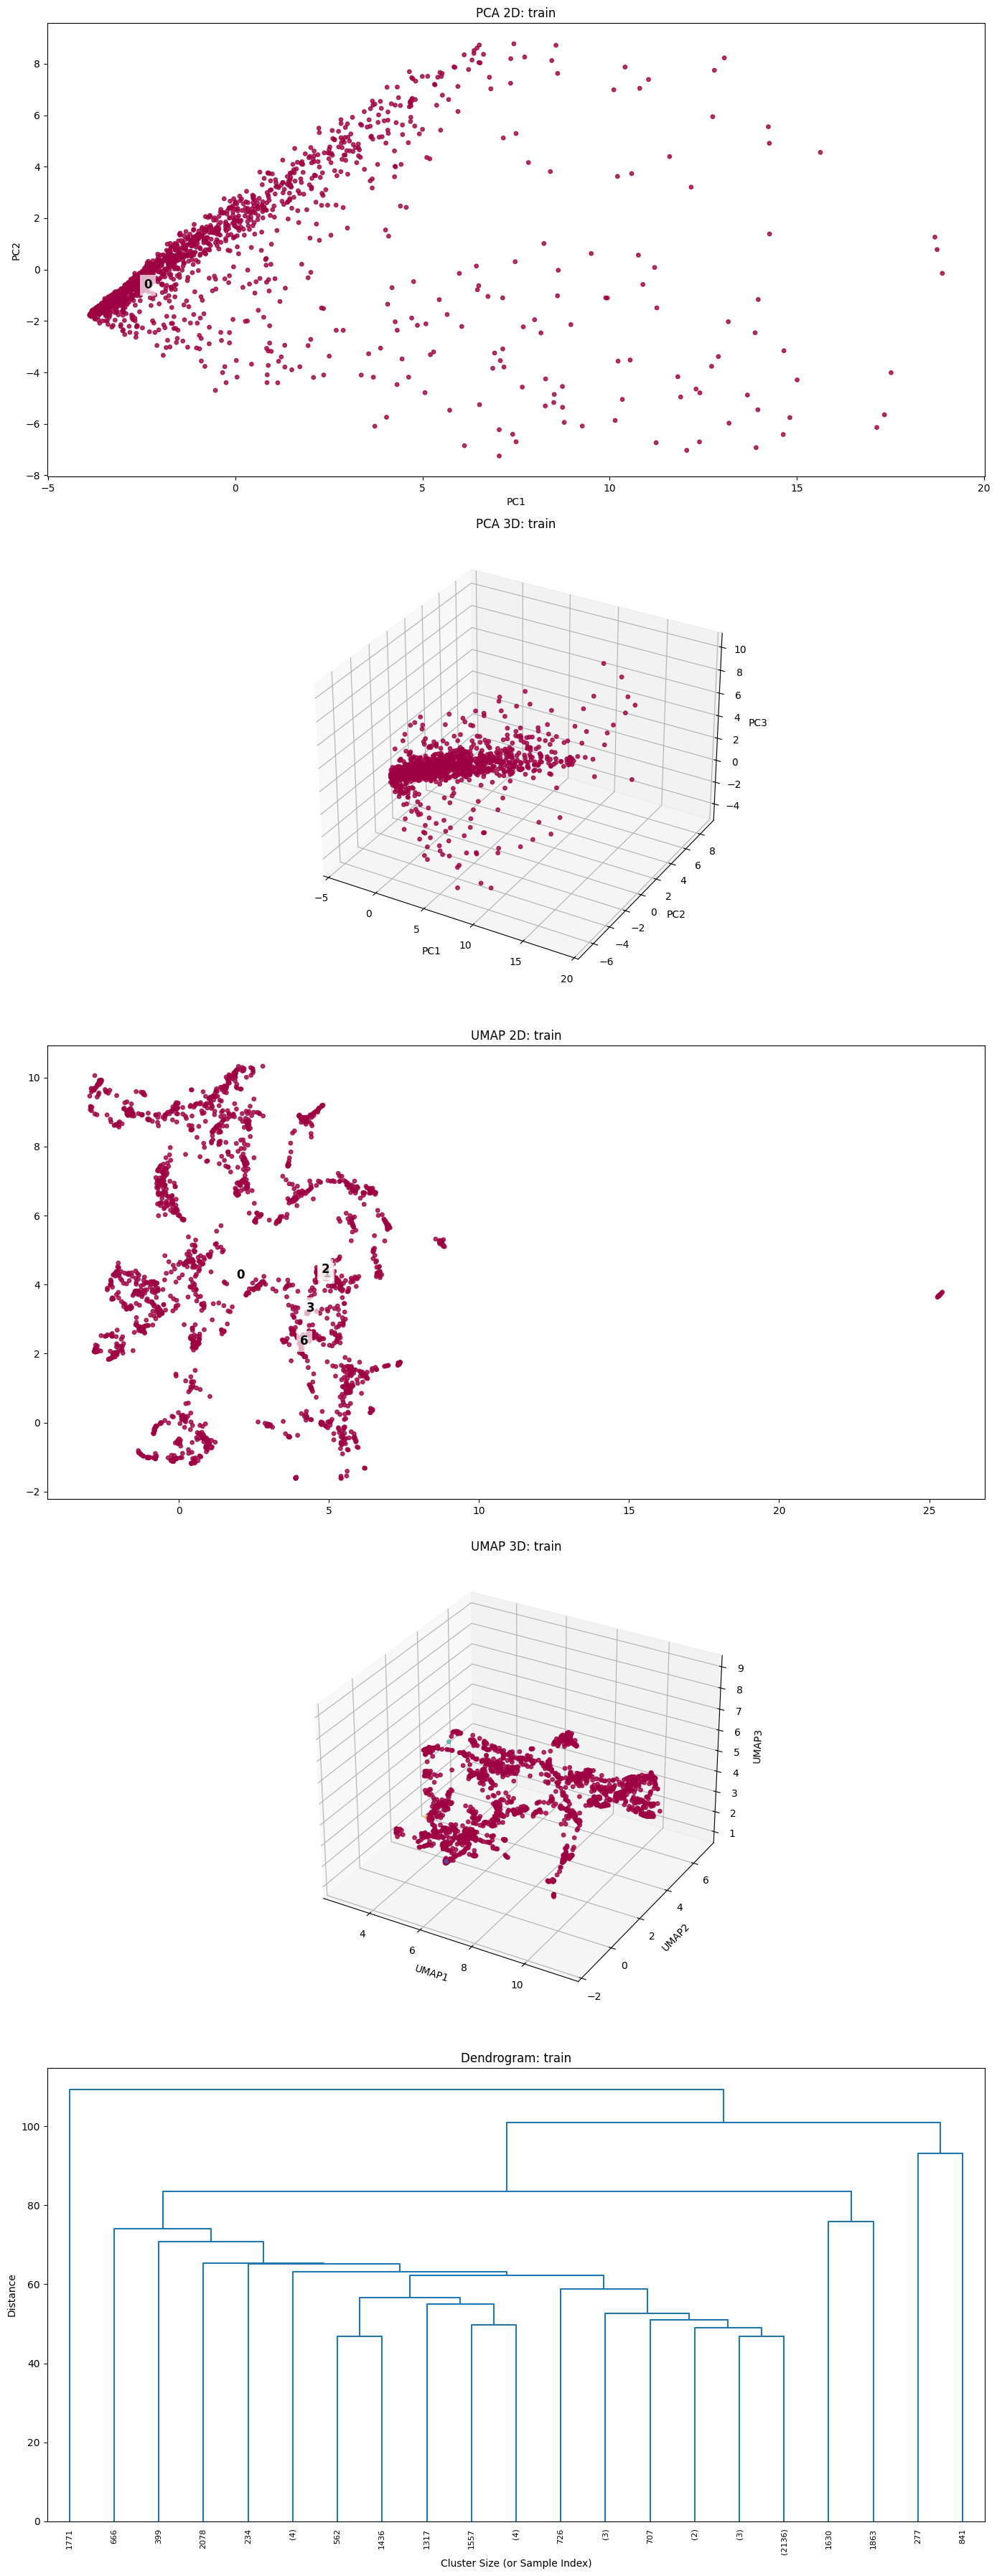

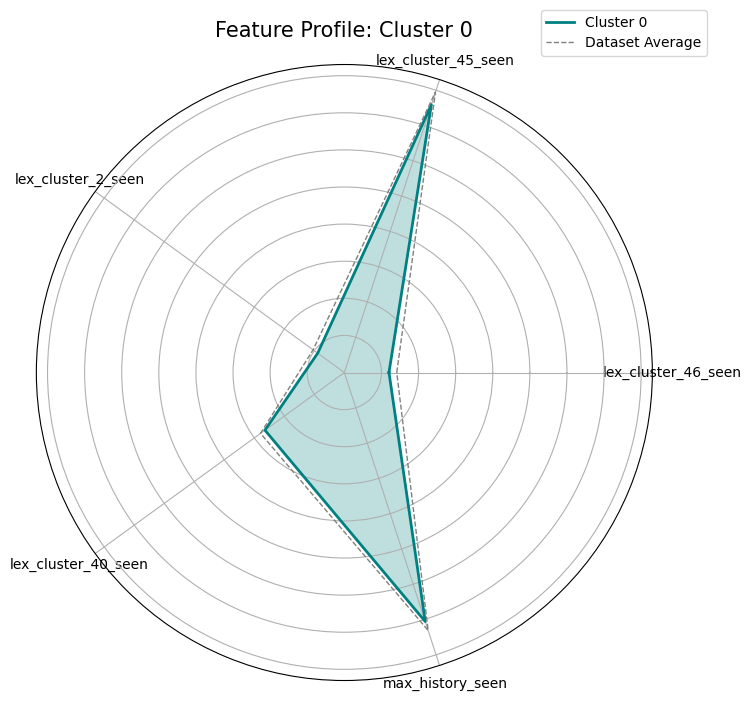

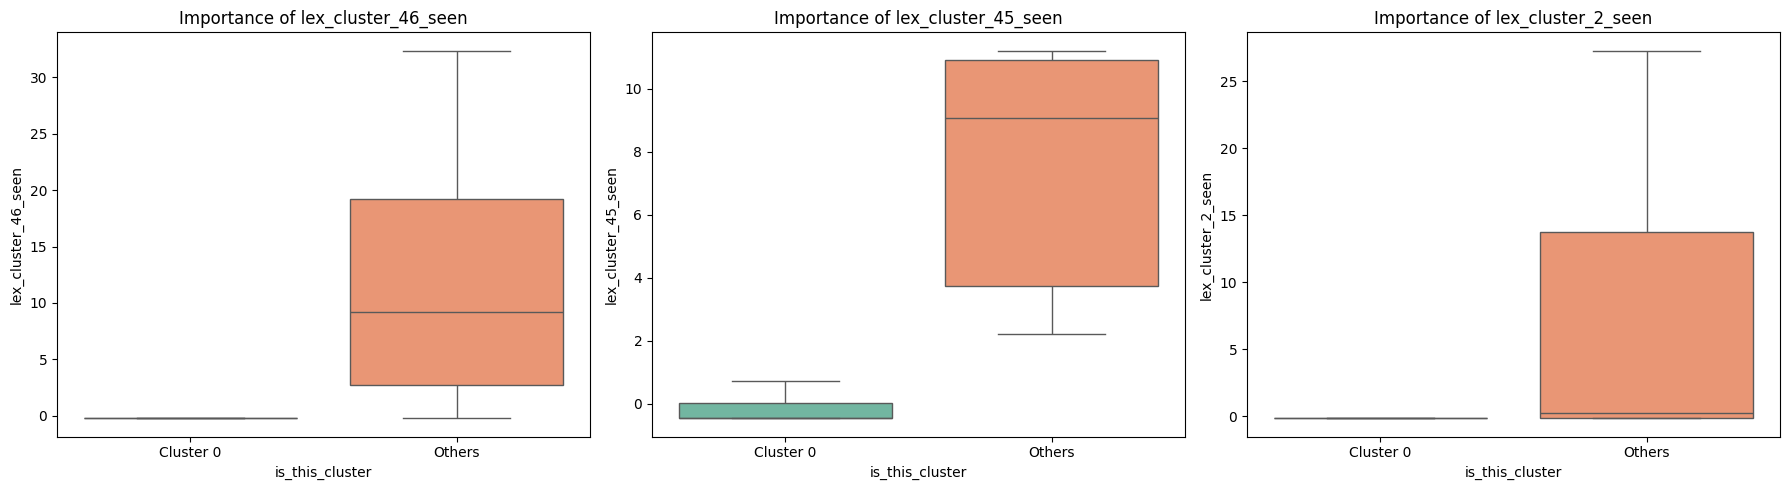

In [ ]:
"""
AHC (Agglomerative Hierarchical Clustering) — Drop-in replacement for HDBSCAN notebook
========================================================================================
Place AHC.py in src/models/ and visualize_ahc.py in src/evaluation/
Then run this notebook as-is.
"""

import pandas as pd

# ── 1. Load Data ──────────────────────────────────────────────────────────────
df_base = pd.read_csv("../data/users_fingerprint_norm.csv").set_index("user_id").drop(columns=["Unnamed: 0"])
df_1a = pd.read_csv("../data/user_embedding_svd_ability_seen_beh.csv").set_index("user_id")
df_1b = pd.read_csv("../data/user_embedding_svd_ability_seen_beh_B.csv").set_index("user_id")
df_2a = pd.read_csv("../data/user_embedding_svd512_ae128_plus_beh.csv").set_index("user_id")
df_2b = pd.read_csv("../data/user_embedding_svd512_ae128_plus_beh_B.csv").set_index("user_id")
df_3  = pd.read_csv("../data/user_fingerprint_B_lex_clusters_scaled.csv").set_index("user_id").drop(columns=["Unnamed: 0"])

print(df_base.shape)
print(df_1a.shape)
print(df_1b.shape)
print(df_2a.shape)
print(df_2b.shape)
print(df_3.shape)

# ── 2. Hopkins Statistic (same as HDBSCAN) ───────────────────────────────────
from src.evaluation.metrics import hopkins_statistic

for df in [df_base, df_1a, df_1b, df_2a, df_2b, df_3]:
    score = hopkins_statistic(df.values)
    print(f"Hopkins Statistic: {score:.4f}")

# ── 3. Run AHC Pipeline ──────────────────────────────────────────────────────
from src.models.ahc import run_ahc_pipeline, save_clustering_results, get_all_cluster_importances
from src.evaluation.visualize_ahc import visualize_ahc_with_labels, plot_cluster_top_features_boxplot, plot_cluster_top_features_radar

# datasets = {
#     "baseline": df_base,
#     "svd": df_1a,
#     "svd_B": df_1b,
#     "svd512_ae128": df_2a,
#     "svd512_ae128_B": df_2b,
#     "lex_clusters_B": df_3,
# }


df_train = df_3.sample(frac=0.8)
df_test = df_3.loc[~df_3.index.isin(df_train.index)]

datasets = {
    # "test": df_test,
    "train": df_train
}


for name, df in datasets.items():
    print(f"\n--- Processing: {name} ---")

    processed_df, model, Z = run_ahc_pipeline(
        df.reset_index(),
        n_components=min(df.shape[1], N_COMPONENTS),
        n_clusters=N_CLUSTERS,
        linkage_method=LINKAGE_METHOD,
        distance_threshold=DISTANCE_THRESHOLD,
    )
    
    save_clustering_results(processed_df, model, Z, name, "../data/tmp/ahc")

    feature_cols = [c for c in processed_df.columns if c not in ['user_id', 'cluster_label']]
    importance_dict = get_all_cluster_importances(processed_df, feature_cols)

    visualize_ahc_with_labels(processed_df, Z, name, "../data/tmp/ahc/plots", outlier_percentile=OUTLIER_PERCENTILE)

# ── 4. Inspect Individual Clusters ───────────────────────────────────────────
# Example: inspect cluster 0 from the last processed dataset
plot_cluster_top_features_radar(processed_df, 0, importance_dict)
plot_cluster_top_features_boxplot(processed_df, 0, importance_dict)